In [ ]:
%%capture
!pip install -r requirements.txt

# Fine-Tune a Vision Transformer for food classification

ViT is a Transformer model architecture designed for computer vision tasks. First introduced in [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al[^1], the team succesfully leveraged the Transformer architecture, known widely as the de-facto system for NLP tasks, to compete with the performance of state of the art computer vision tasks through CNN (Convolutional Neural Networks).

In this notebook, we will fine-tune this Google's ViT model on a food classification task using Domino. We will also leverage Domino's deep integration with MLFlow to track our model performance and log our resulting model to MLFlow.


[^1]: Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, Neil Houlsby_

In [ ]:
from datasets import load_dataset
from transformers import AutoImageProcessor


# Inputs from the user
DATASET_NAME = "food101"
MODEL_NAME = "google/vit-base-patch16-224-in21k"
IMAGE_COL = "image"
LABEL_COL = "label"
LOG_MODEL_MLFLOW = True
LOG_DATA_MLFLOW = True

ds = load_dataset(DATASET_NAME)
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

## Conversion from Pandas

If you have a pandas dataframe with your images, you can use the helper function below to convert it to huggingface.

In [ ]:
import pandas as pd
from datasets import ClassLabel, Dataset, DatasetDict

def pandas_to_hf(df: pd.DataFrame) -> DatasetDict:
    """Convert a pandas df into a huggingface dataset dict"""
    ds = Dataset.from_pandas(df)
    labels = sorted(df[LABEL_COL].unique())
    class_label = ClassLabel(num_classes=len(labels), names=labels)
    ds = ds.cast_column(LABEL_COL, class_label)
    return DatasetDict({"train": ds})

# ds = pandas_to_hf(df)


## Train-test Split

We will split our dataset into train and test. This code handles a few different cases, handling different key names

In [ ]:
from PIL.Image import Image as PIL_Image
from datasets import Dataset

# If the dataset dict only has 1 key, we want to split it into train/test
if len(ds.keys()) == 1:
    key = next(iter(ds.keys()))
    ds = ds[key]

# If we have a dataset, we want to create a dict with train/test
if isinstance(ds, Dataset):
    ds = ds.train_test_split(test_size=0.2, stratify_by_column=LABEL_COL)


splits = list(ds.keys())
train_split = "train" if "train" in splits else "training"
eval_split = next(split for split in splits if split != train_split)

print("DatasetDict:", ds)
print("Train Split:", train_split)
print("Test Split:", eval_split)

DatasetDict: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
Train Split: train
Test Split: validation


## Important: Ensure your data is in PIL Format!

_Let's look at our first image_

Label: bibimbap


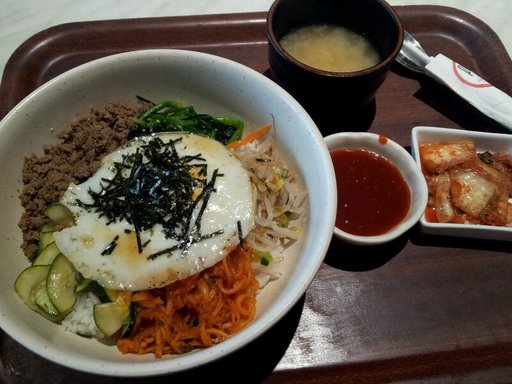

In [ ]:
# Some validation - Must be a PIL image
assert isinstance(ds[train_split][0][IMAGE_COL], PIL_Image), "Data must have PIL images loaded to train"

# View a random sample
labels = ds[train_split].features[LABEL_COL].names
image_id = 68250
print("Label:", labels[ds[train_split][image_id][LABEL_COL]])
ds[train_split][image_id][IMAGE_COL]

## Preprocessing

We'll apply some standard image preprocessing. You can add any more transformations you see fit in this cell, and add them to the `Compose` list below.

Here, we do a [Random Crop Resizing](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html) which entails cropping a component of an image, and resizing that crop to the original image size.

Then, we normalize all images to the mean and std deviation.

In [ ]:
# Standard image preprocessing. Feel free to add more!
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from typing import Dict, List

# Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
transformations = Compose([RandomResizedCrop(size), ToTensor(), normalize])


def transforms(examples: Dict[str, List]):
    """Apply the transformations and return the pixel_values"""
    examples["pixel_values"] = [transformations(img.convert("RGB")) for img in examples[IMAGE_COL]]
    del examples[IMAGE_COL]
    return examples


ds = ds.with_transform(transforms)

## Evaluation

In Computer Vision, accuracy is a very common evaluation metric to use. But you can change this and load in any pre-loaded `evaluate` metric, or create your own by writing custom code in the `compute_metrics` function.

In [ ]:
from transformers import DefaultDataCollator
import evaluate
from evaluate import EvaluationModule
import numpy as np


EVAL_METRIC = "accuracy"
metric = evaluate.load(EVAL_METRIC)

def compute_metrics(eval_pred: EvaluationModule):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


## Training!

Here we begin training. We first set mlflow autologging to True so metrics and parameters are automatically logged.

We then set up our id to label mapping for the foundational model.

Next, we load our ImageClassification pre-trained model that we defined in the first cell, and give it the labels that we have.

Last, we set our training arguments and trainer parameters, and begin training!

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import mlflow.transformers
import os


mlflow.transformers.autolog(
    log_input_examples=LOG_DATA_MLFLOW,
    log_model_signatures=LOG_MODEL_MLFLOW,
    log_models=LOG_MODEL_MLFLOW,
    log_datasets=LOG_DATA_MLFLOW
)

# Mappings to/from labels and ids
labels = ds[train_split].features[LABEL_COL].names
id2label = dict(enumerate(labels))
label2id = {v: k for k, v in id2label.items()}

data_collator = DefaultDataCollator()

model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

mlflow_run_name = "food-classification-run1"

training_args = TrainingArguments(
    output_dir=mlflow_run_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model=EVAL_METRIC,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds[train_split],
    eval_dataset=ds[eval_split],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

## Logging your Data and Models to MLFlow

If you've set either these values to True, we will log the model checkpoints and input dataset to MLFlow directly within Domino.

In [ ]:
# Log the dataset and model to mlflow
run_id = mlflow.last_active_run().info.run_id
with mlflow.start_run(run_id=run_id):
    if LOG_MODEL_MLFLOW:
        model_config = {
            "model": trainer.model,
            "image_processor": trainer.tokenizer
        }
        mlflow.transformers.log_model(model_config, artifact_path="model")
    if LOG_DATA_MLFLOW:
        for split in ds.keys():
            data = mlflow.data.from_huggingface(ds[split])
            mlflow.log_input(data, context=split)


<ipython-input-14-11fda04f2ae8>:9: FutureWarning: The 'transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``4.25.1`` -  ``4.33.1``. MLflow Models integrations with transformers may not succeed when used with package versions outside of this range.
  mlflow.transformers.log_model(model_config, artifact_path="model")
/usr/local/lib/python3.10/dist-packages/mlflow/models/model.py:579: FutureWarning: The 'transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``4.25.1`` -  ``4.33.1``. MLflow Models integrations with transformers may not succeed when used with package versions outside of this range.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


2023/10/21 16:25:48 WARNING mlflow.transformers: This model is unable to be used for pyfunc prediction because the model is not a language-based model and requires a complex input type that is currently not supported. The pyfunc flavor will not be added to the Model.
2023/10/21 16:25:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/21 16:25:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.16.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `

## Use our fine-tuned model

Lastly, we can save the model directly to disk, and load it to make predictions

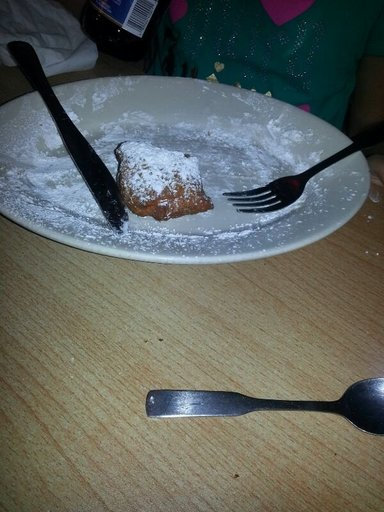

Label: beignets
Prediction: beignets



[{'score': 0.04597856104373932, 'label': 'beignets'},
 {'score': 0.029794666916131973, 'label': 'cannoli'},
 {'score': 0.02709176205098629, 'label': 'donuts'},
 {'score': 0.017459828406572342, 'label': 'waffles'},
 {'score': 0.01583888940513134, 'label': 'french_toast'}]

In [ ]:
from transformers import pipeline


trainer.save_model(f"/mnt/artifacts/{mlflow_run_name}")
classifier = pipeline("image-classification", model=f"/mnt/artifacts/{mlflow_run_name}")

# Get the raw image
record = load_dataset(DATASET_NAME)["train"][0]
image = record[IMAGE_COL]
label = record[LABEL_COL]

display(image)
print("Label:", labels[label])
preds = classifier(image)
print("Prediction:", preds[0]["label"], end="\n\n")
preds